In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score


random.seed(42)
np.random.seed(42)

Все разработанные функции, которые используются для обучения итоговой модели, помещены в файлы `utils.py` и `tfidf_utils.py`. В первом файле — функции для формирования датасета, обработки текстов и построения диаграмм, во втором — функции и классы для обучения модели, основанной на TF-IDF. Импортируем:

In [2]:
from utils import *
import tfidf_utils as tfidf

In [3]:
OFFSET = 50

## Формирование датасета

Создаем датафрейм с сырыми данными из текстовых файлов и сохраняем в csv. Столбцы: автор *(по названию папки)*, фамилия автора на русском *(из файла AUTHOR.txt в каждой папке)*, название произведения, текст произведения. Тексты должны располагаться в директориях с адресом вида {`dir_path`}/{`dataset_name`}/ИМЯ_АВТОРА (для каждого автора — отдельная папка). 

In [4]:
%%time
for ds in ['train', 'test']:
    df_raw = df_from_txt_files(ds.upper())
    output_path = f'./datasets/raw_{ds.upper()}.csv'
    df_raw.to_csv(output_path, index=False)

CPU times: total: 2.78 s
Wall time: 2.79 s


In [5]:
df_train_raw = pd.read_csv('datasets/raw_TRAIN.csv')
df_test_raw = pd.read_csv('datasets/raw_TEST.csv')

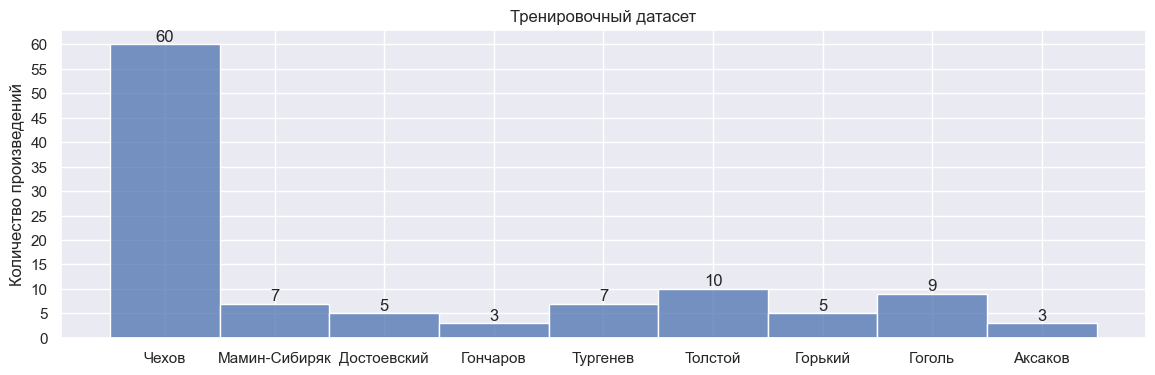

In [6]:
show_work_titles_histplot(df_train_raw, title='Тренировочный датасет')

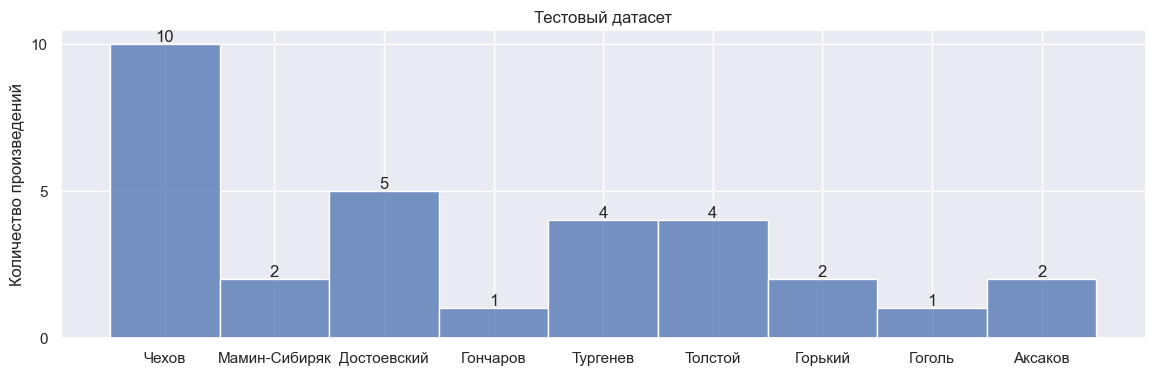

In [7]:
show_work_titles_histplot(df_test_raw, title='Тестовый датасет')

In [8]:
df_train_raw.sample(3)

,author,author_surname,work_title,text
78,ivan-turgenev,Тургенев,rudin,I Было тихое летнее утро. Солнце уже довольно ...
10,anton-chekhov,Чехов,beseda-pyanogo-s-trezvym-chertom,Беседа пьяного с трезвым чёртом Бывший чиновн...
4,anton-chekhov,Чехов,ariadna,"Ариадна На палубе парохода, шедшего из Одессы ..."


### Разбиение произведений на отрывки по $\approx250$ слов

Для разбиения текста написан генератор отрывков `excerpt_generator`. Отрывок подбирается так, чтобы первое и последнее предложения в нем входили в него целиком. Первый аргумент — разбиваемый текст, второй — минимальная длина отрывка в словах, третий — отступ (в словах) начала очередного отрывка от начала предыдущего (если отступ меньше длины отрывка, то отрывки пересекаются). Пример разбиения текста:

In [9]:
example = "\n... Раз. Два! Три? Четыре… Пять?! "+\
          "Шесть, семь, восемь, девять. Десять!!! Одиннадцать..."+\
          "Двенадцать, тринадцать, четырнадцать. Пятнадцать."
list(excerpt_generator(example, 2, 1))

['Раз. Два!',
 'Два! Три?',
 'Три? Четыре…',
 'Четыре… Пять?!',
 'Пять?! Шесть, семь, восемь, девять.',
 'Шесть, семь, восемь, девять.',
 'Десять!!! Одиннадцать...',
 'Одиннадцать... Двенадцать, тринадцать, четырнадцать.',
 'Двенадцать, тринадцать, четырнадцать.']

Чтобы получить побольше данных для обучения, для тренировочного датасета смещение зададим небольшое: вего 50 слов. На тестовом датасете, вероятно, правильнее будет установить смещение, равное длине отрывка (250 слов), чтобы отрывки получились разнородные (не пересекались) и не искажали оценку модели.

In [10]:
df_train = make_dataset_of_excerpts(df_train_raw, 250, offset=OFFSET)
df_test = make_dataset_of_excerpts(df_test_raw, 250, offset='excerpt_len')

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.59it/s]


In [11]:
df_train.to_csv(f'datasets/TRAIN_250words_offset{OFFSET}.csv', index=False)
df_test.to_csv(f'datasets/TEST_250words_offset250.csv', index=False)

In [12]:
df_train = pd.read_csv(f'datasets/TRAIN_250words_offset{OFFSET}.csv')
df_test = pd.read_csv(f'datasets/TEST_250words_offset250.csv')

In [13]:
df_train.shape

(81185, 5)

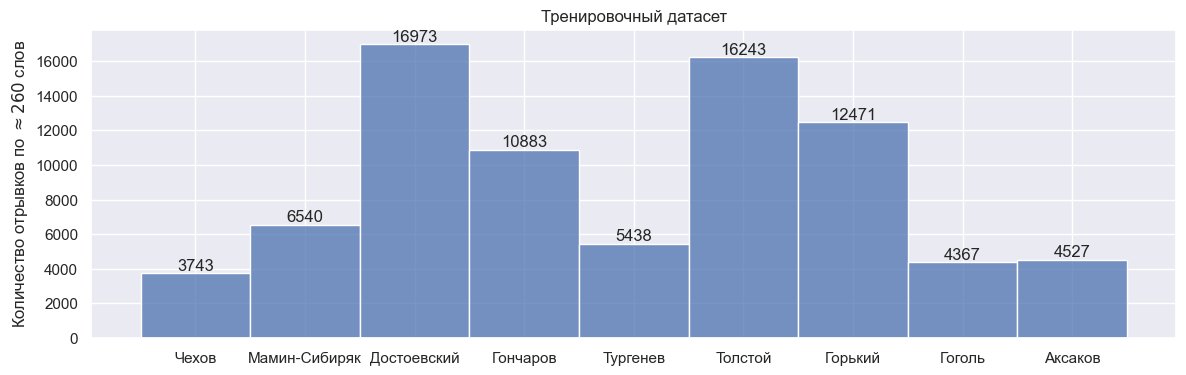

In [14]:
show_excerpts_histplot(df_train, 'Тренировочный датасет')

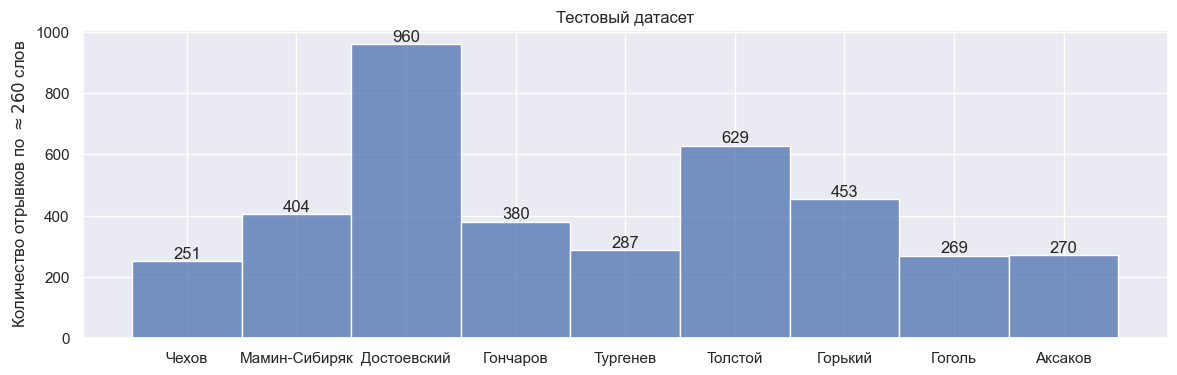

In [15]:
show_excerpts_histplot(df_test, 'Тестовый датасет')

In [16]:
df_test.shape

(3903, 5)

In [17]:
df_test.sample(5)

,author,author_surname,work_title,excerpt_num,text
2436,lev-tolstoi,Толстой,kazaki,36,"Еще дальше и вода, и берег, и туча — все слива..."
1707,ivan-goncharov,Гончаров,obyknovennaya-istoriya,92,"Ее одевают в газ, в блонды, убирают цветами и,..."
1728,ivan-goncharov,Гончаров,obyknovennaya-istoriya,113,"да! бесполезными, а между тем в те минуты душа..."
1610,fedor-dostoevskii,Достоевский,prestuplenie-i-nakazanie,673,Никогда не считали непоколебимее своих пригово...
1266,fedor-dostoevskii,Достоевский,prestuplenie-i-nakazanie,329,"И уж прижму ж я его, по-родственному ; пусть в..."


### Добавление столбца с леммами 

In [18]:
# Поддерживается многопоточность (`n_jobs` - число потоков).
for df in [df_train, df_test]:
    add_lemmas_column(df, inplace=True, verbose=1, n_jobs=10)

100%|███████████████████████████████████████████████████████████████████████████| 81185/81185 [04:00<00:00, 337.17it/s]
C:\Users\Grok\Documents\НИУ ВШЭ\МОВС\1 курс\Проект\utils.py:277: UserWarning: Не все тексты удалось лемматизировать. Возможно, они полностью состоят из стоп-слов или написаны латиницей. Тексты с NaN-значениями в столбце lemmas были удалены.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████| 3903/3903 [00:15<00:00, 245.98it/s]


In [19]:
df_train.to_csv(f'datasets/TRAIN_250words_lemmatized_offset{OFFSET}.csv', index=False)
df_test.to_csv(f'datasets/TEST_250words_lemmatized_offset250.csv', index=False)

In [20]:
df_train = pd.read_csv(f'datasets/TRAIN_250words_lemmatized_offset{OFFSET}.csv')
df_test = pd.read_csv(f'datasets/TEST_250words_lemmatized_offset250.csv')

In [21]:
df_train.sample(3)

,author,author_surname,work_title,excerpt_num,text,lemmas
30676,ivan-goncharov,Гончаров,fregat-pallada,3420,Занять иных образцов неоткуда. Все собственные...,занять иной образец неоткуда собственный источ...
46745,lev-tolstoi,Толстой,anna-karenina,3168,"Он улыбнулся, однако, и подошел к Кити. — Ну, ...",улыбнуться однако подойти кить спросить самый ...
3065,anton-chekhov,Чехов,tri-sestry,158,"Сегодня я играть не стану, только так посижу. ...",сегодня играть стать посидеть нездоровиться де...


In [22]:
df_test.sample(3)

,author,author_surname,work_title,excerpt_num,text,lemmas
1863,ivan-goncharov,Гончаров,obyknovennaya-istoriya,248,Когда он вошел… невозможно описать этого взгля...,войти невозможно описать взгляд который встрет...
2939,maksim-gorkii,Горький,foma-gordeev,28,"А лоцман-то новый уж, — объявил Фома. — Знаем…...",лоцман новый объявить фома знать добрый здоров...
3326,maksim-gorkii,Горький,moi-universitety,101,"Отец проклял его за строптивость и, проходя ми...",отец проклясть строптивость проходить мимо нов...


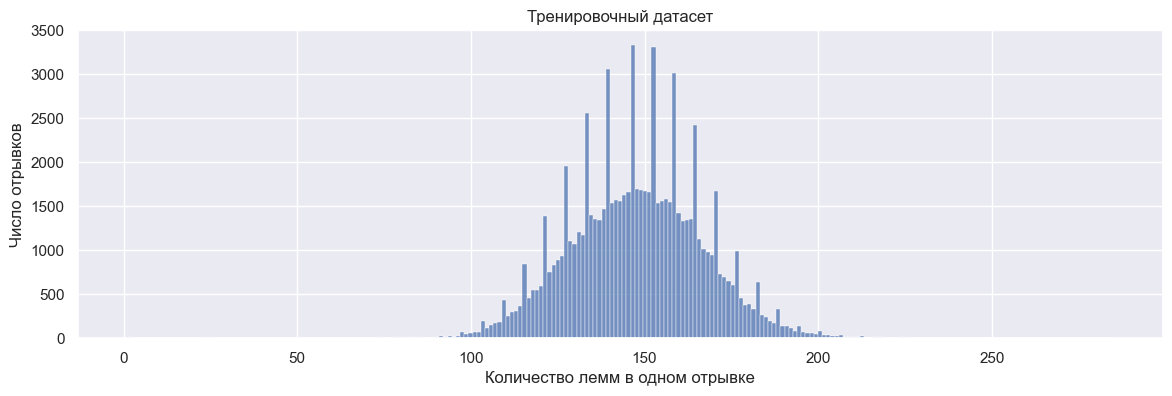

In [23]:
show_lemmas_histplot(df_train, 'Тренировочный датасет')

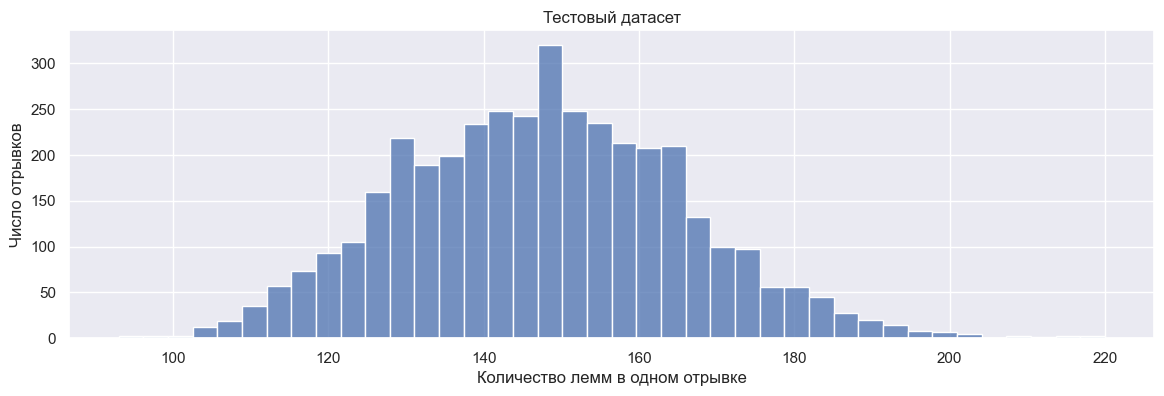

In [24]:
show_lemmas_histplot(df_test, 'Тестовый датасет')

## Обучение и оценка модели

Обучаем модель с помощью класса-пайплайна `AuthorIdentificationTfidfPipeline` из `tfidf_utils.py`.

In [6]:
# Инициализируем пайплайн-классификатор
pipe = tfidf.AuthorIdentificationTfidfPipeline()

Методу *fit* передается либо один аргумент: датафрейм **X**, если в нем есть столбец *author*; 

либо два аргумента: датафрейм **X** без стобца *author* и столбец **y** с авторами.

In [7]:
%%time
pipe.fit(df_train)

CPU times: total: 3min 57s
Wall time: 3min 21s


In [8]:
%%time
pred_test = pipe.predict(df_test)

CPU times: total: 9 s
Wall time: 9.01 s


#### F1-score

In [9]:
f1_score(df_test.author, pred_test, average='weighted')

0.9326376331537092

#### Для сравнения, простейший бейзлайн (мажоритарный класс)

In [10]:
def baseline(df_train, df_test):
    pred = df_train.groupby(by='author').count()['text'].idxmax()
    return [pred for i in range(df_test.shape[0])]

In [11]:
pred_test_baseline = baseline(df_train, df_test)
f1_score(df_test.author, pred_test_baseline, average='weighted')

0.09711127159338828

#### Confusion matrix

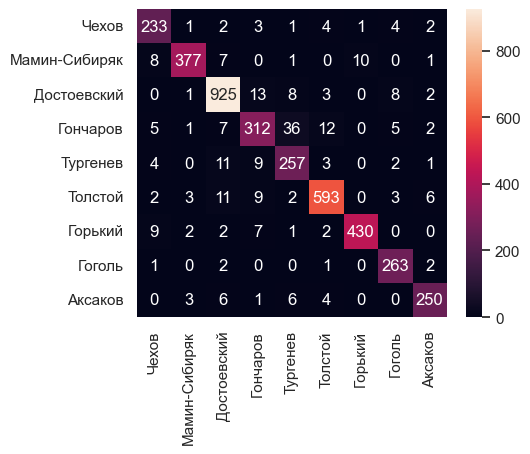

In [12]:
plot_confusion_matrix(df_test.author, pred_test, author_rus_surnames(df_train))

Чтобы получить более читаемую матрицу ошибок, сгенерируем сбалансированный тестовый датасет: с помощью функции `undersampling` удалим из имеющегося датасета случайные тексты у каждого автора в количестве, необходимом для уравнивания численности классов. Сделаем так три раза (на разных подмножествах).

0.9281869592775457


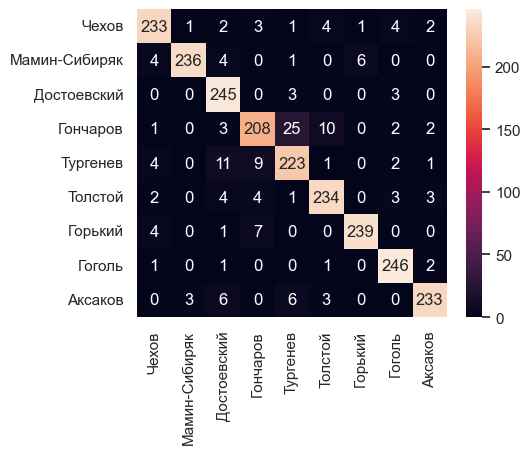

0.9251474764595292


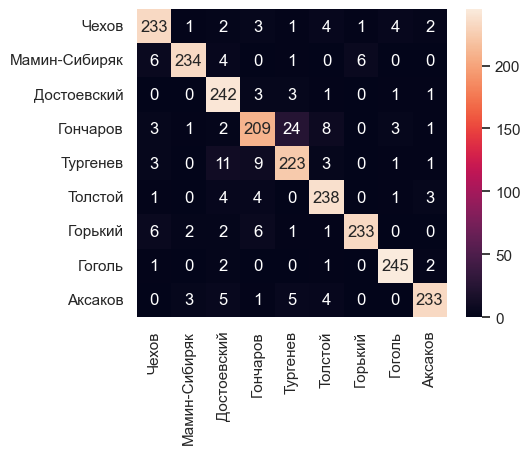

0.9227103414282226


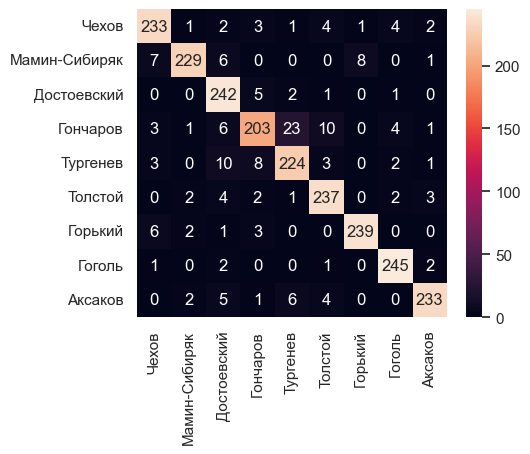

CPU times: total: 16.6 s
Wall time: 16.6 s


In [15]:
%%time
for i in range(3):
    df_test_u = undersampling(df_test)
    pred_test_u = pipe.predict(df_test_u)
    print(f1_score(df_test_u.author, pred_test_u, average='weighted'))
    plot_confusion_matrix(df_test_u.author, pred_test_u, author_rus_surnames(df_train))

В целом, результаты неплохие; заметные проблемы есть только с классификацией текстов Гончарова: автором его текстов модель иногда считает Тургенева. Лучше всего модель узнает Гоголя и Достоевского.

#### Список ошибочно классифицированных объектов

In [16]:
fp = false_predictions(df_test, pred_test)
print(fp.shape)
fp.sample(5)

(263, 7)


,y_true,y_pred,author_surname,work_title,excerpt_num,text,lemmas
2507,lev-tolstoi,ivan-goncharov,Толстой,kazaki,107,"думал Лукашка. — Конь-то у меня, а там видно б...",думать лукашка конь видно малый промах кто про...
483,dmitriy-mamin-sibiryak,anton-chekhov,Мамин-Сибиряк,cherty-iz-zhizni-pepko,232,Для меня это было задачей. В последнее время П...,это задача последний время пепко начать приход...
3348,maksim-gorkii,lev-tolstoi,Горький,moi-universitety,123,"Тяжёлые шаги на лестнице; согнувшись в двери, ...",тяжёлый шаг лестница согнуться дверь войти ром...
3358,maksim-gorkii,ivan-goncharov,Горький,moi-universitety,133,"Это, в сущности, добрые звери, — любого из них...",это сущность добрый зверь любой нетрудно заста...
338,dmitriy-mamin-sibiryak,maksim-gorkii,Мамин-Сибиряк,cherty-iz-zhizni-pepko,87,"Стены толстые, каменные, окошко маленькое, с ж...",стена толстый каменный окошко маленький железн...


### Для сравнения, один из классических методов (Дельта Бёрроуза)

In [23]:
from burrows_delta import Corpus
import burrows_delta

train_crp = Corpus(
    authors=df_train.author.to_list(), 
    books=df_train.apply(lambda row: f'{row.work_title}_{row.excerpt_num}', axis=1).to_list(), 
    tokens=df_train.lemmas.to_list()
)

test_crp = Corpus(
    authors=df_test.author.to_list(), 
    books=df_test.apply(lambda row: f'{row.work_title}_{row.excerpt_num}', axis=1).to_list(), 
    tokens=df_test.lemmas.to_list()
)

In [24]:
%%time
df_b_delta = burrows_delta.calculate_burrows_delta(train_crp, test_crp, vocab_size=5000)
pred_test_b_delta = df_b_delta.T.columns[df_b_delta.apply(np.argmin, axis=0)]

CPU times: total: 43.1 s
Wall time: 43.2 s


In [25]:
f1_score(df_test.author, pred_test_b_delta, average='macro')

0.2200924643550525

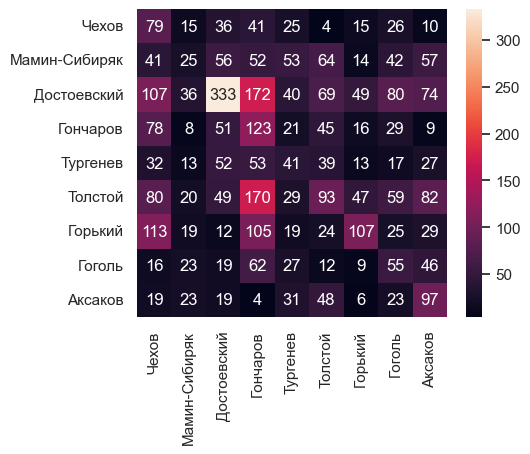

In [26]:
plot_confusion_matrix(df_test.author, pred_test_b_delta, author_rus_surnames(df_train))